# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

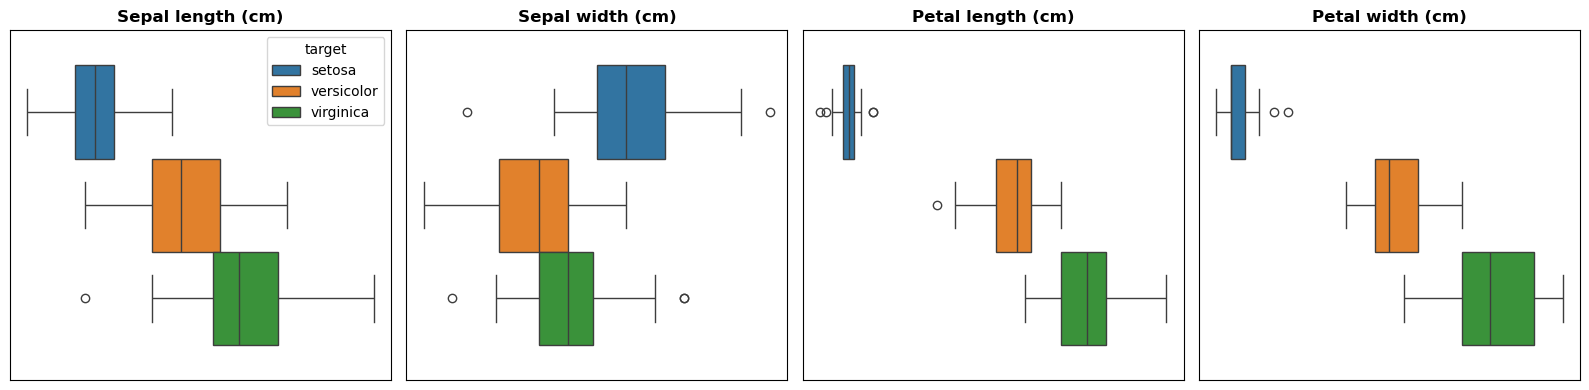

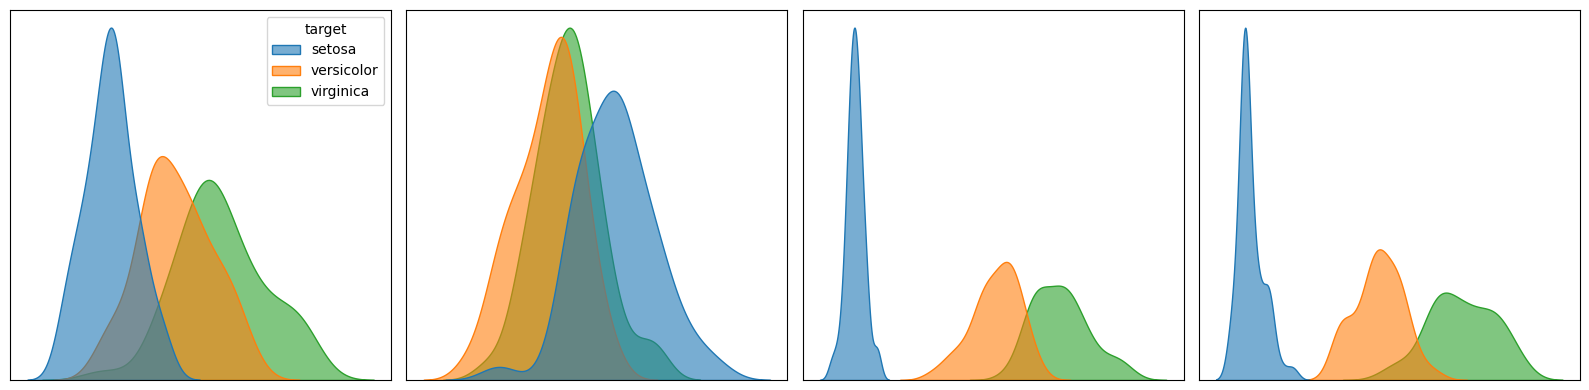

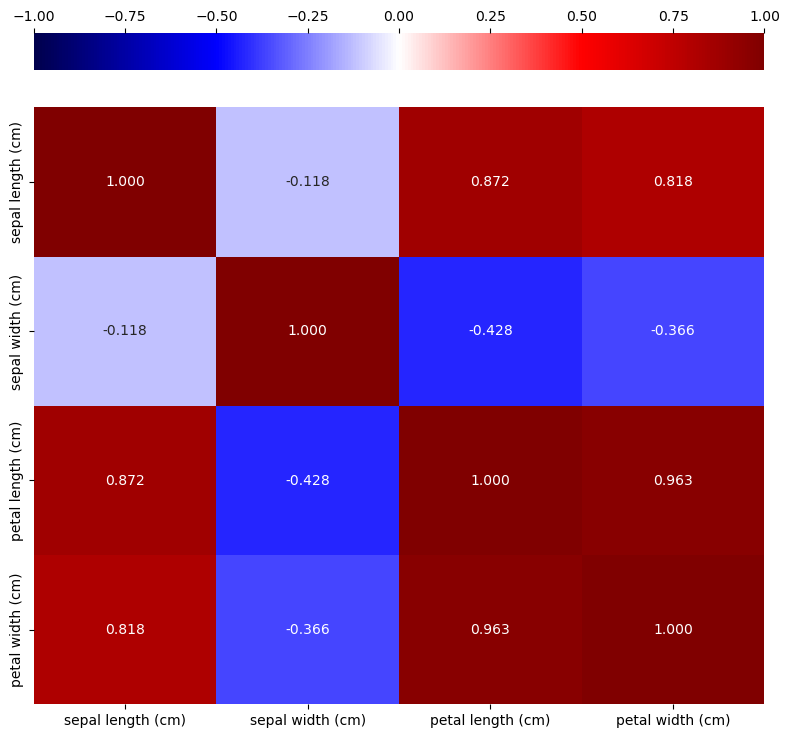

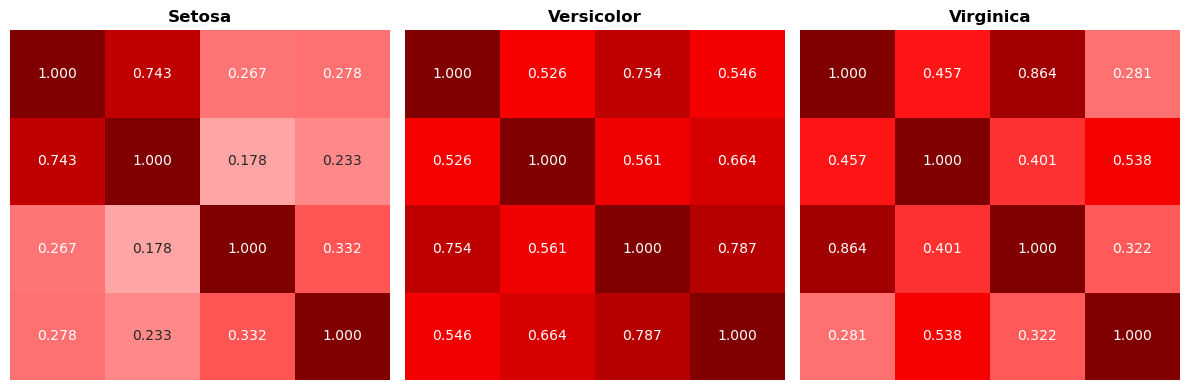

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,3.343913,2.878754,0.324915,-0.755435,setosa
1,5.356547,3.433807,-0.815127,-0.330769,setosa
2,4.481475,3.516252,1.751135,1.184393,setosa
3,3.173752,2.893572,2.043552,0.318970,setosa
4,5.008943,2.480090,0.777163,0.851335,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.003      5.996   
     sepal width (cm)   3.428      2.770     2.974     3.487      2.854   
     petal length (cm)  1.462      4.260     5.552     1.364      4.274   
     petal width (cm)   0.246      1.326     2.026     0.318      1.537   
STD  sepal length (cm)  0.352      0.516     0.636     1.168      1.026   
     sepal width (cm)   0.379      0.314     0.322     0.931      0.799   
     petal length (cm)  0.174      0.470     0.552     1.067      0.967   
     petal width (cm)   0.105      0.198     0.275     0.906      0.972   
MIN  sepal length (cm)  4.300      4.900     4.900     1.710      3.395   
     sepal width (cm)   2.300      2.000     2.200     1.213      0.916   
     petal length (cm)  1.000      3.000     4.500    -1.097      1.638   
     petal width (cm)   0.100      1.000     1.400    -1.509     -0.829   
MAX  sepal length (cm)  5.800      7.000     7.900     7.642      8.288   
     sepal width (cm)   4.400      3.400     3.800     5.650      4.592   
     petal length (cm)  1.900      5.100     6.900     3.584      5.978   
     petal width (cm)   0.600      1.800     2.500     2.324      3.480   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.074     -0.047   
     sepal width (cm)   0.040     -0.352     0.355     0.168      0.267   
     petal length (cm)  0.103     -0.588     0.533    -0.250     -0.411   
     petal width (cm)   1.216     -0.030    -0.126     0.101     -0.278   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.128     -0.195   
     sepal width (cm)   0.744     -0.448     0.520    -0.084     -0.305   
     petal length (cm)  0.805     -0.074    -0.256    -0.467      0.243   
     petal width (cm)   1.434     -0.488    -0.661    -0.406     -0.262   
IQR  sepal length (cm)  0.400      0.700     0.675     1.412      1.201   
     sepal width (cm)   0.475      0.475     0.375     1.206      1.123   
     petal length (cm)  0.175      0.600     0.775     1.322      1.092   
     petal width (cm)   0.100      0.300     0.500     1.229      1.343   

                                  
                       virginica  
MEAN sepal length (cm)     6.792  
     sepal width (cm)      2.978  
     petal length (cm)     5.554  
     petal width (cm)      1.828  
STD  sepal length (cm)     1.136  
     sepal width (cm)      0.882  
     petal length (cm)     1.045  
     petal width (cm)      0.937  
MIN  sepal length (cm)     4.425  
     sepal width (cm)      1.131  
     petal length (cm)     4.106  
     petal width (cm)     -0.242  
MAX  sepal length (cm)     9.219  
     sepal width (cm)      5.360  
     petal length (cm)     9.260  
     petal width (cm)      3.915  
SKEW sepal length (cm)    -0.095  
     sepal width (cm)      0.156  
     petal length (cm)     1.115  
     petal width (cm)      0.214  
KURT sepal length (cm)    -0.686  
     sepal width (cm)     -0.058  
     petal length (cm)     1.574  
     petal width (cm)     -0.129  
IQR  sepal length (cm)     1.549  
     sepal width (cm)      1.198  
     petal length (cm)     1.425  
     petal width (cm)      1.171

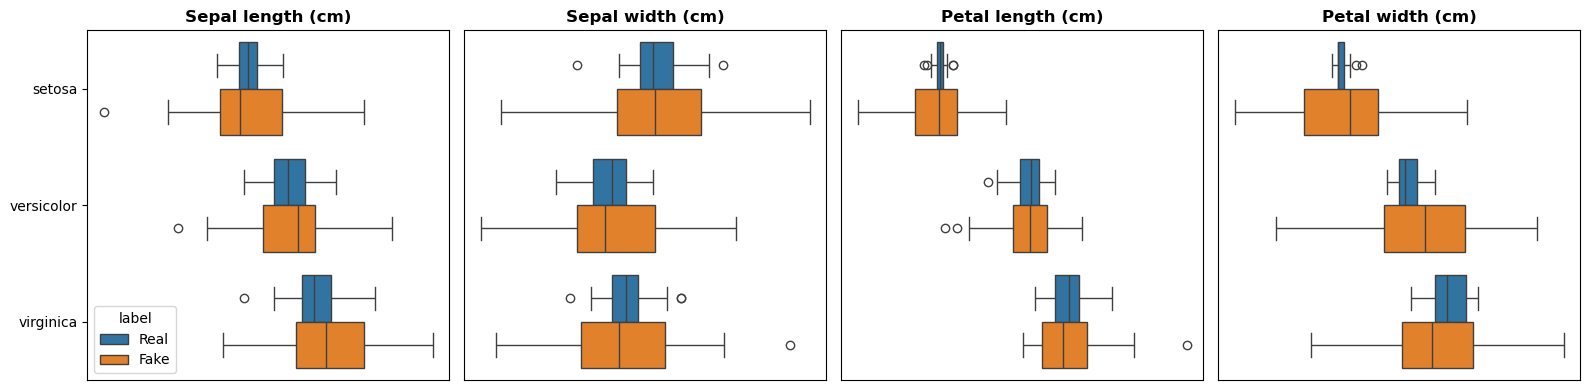

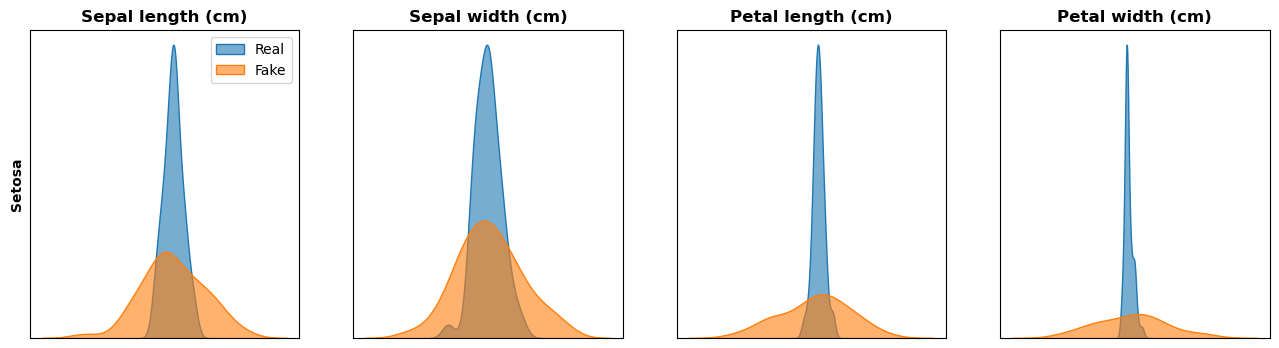

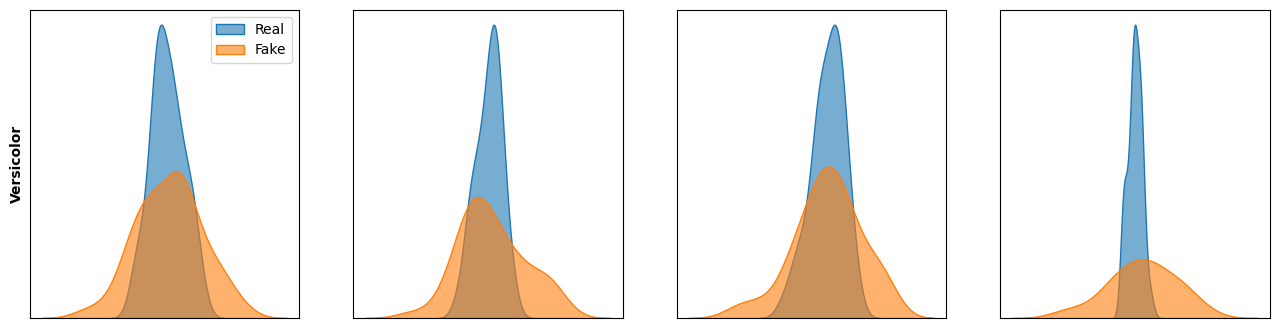

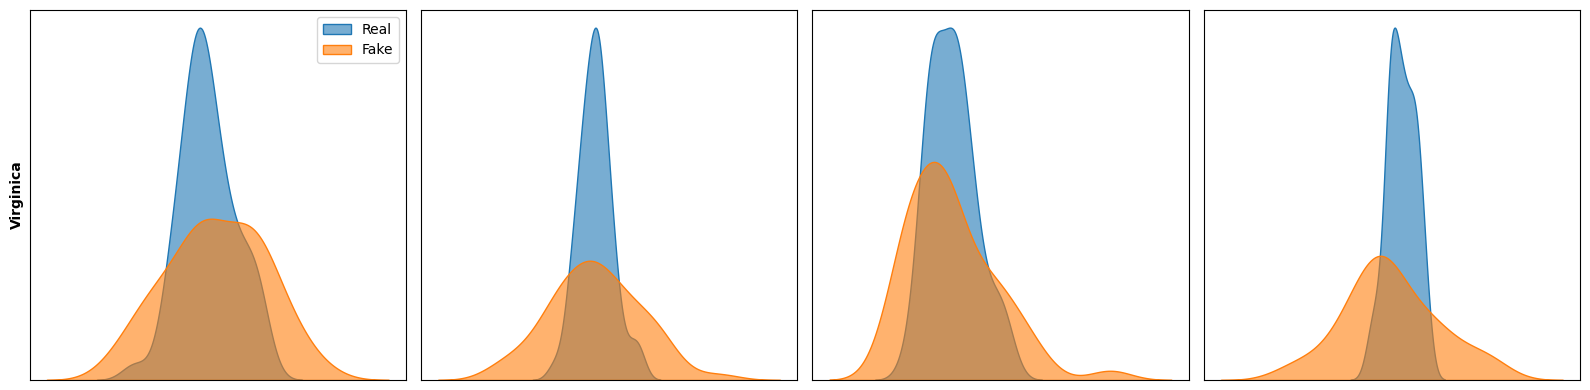

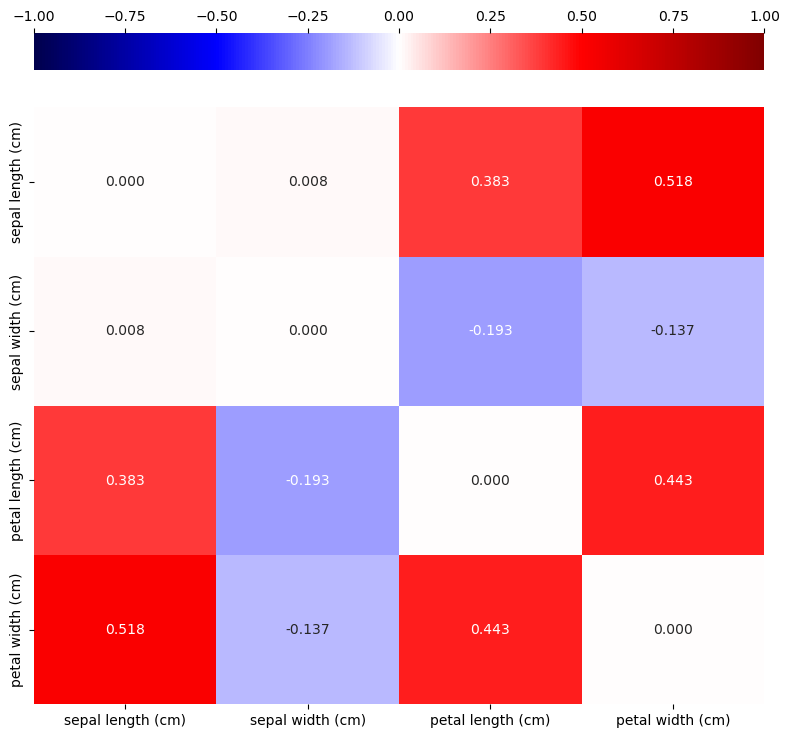

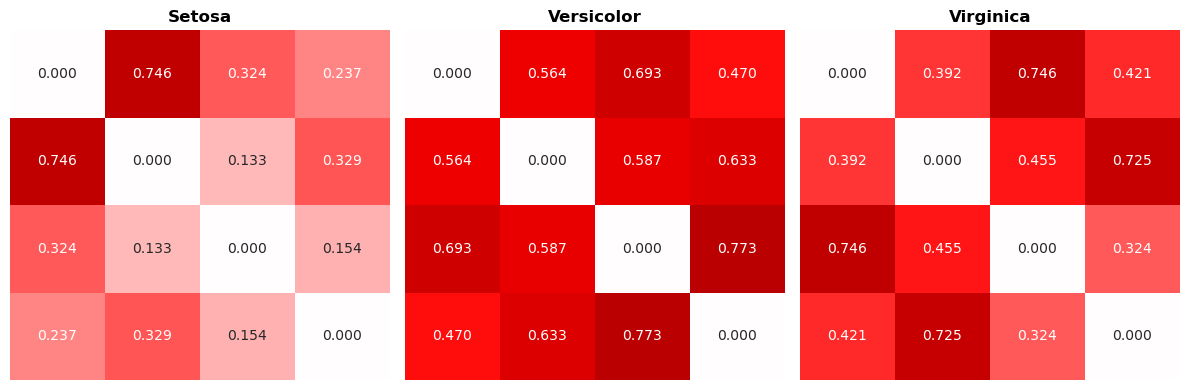

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    

vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 714 parameters


We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()

z = torch.randn(150, 4)

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 10 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/50 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 10/50 | Loss: 0.9310
MEAN: [ 0.025 -0.01   0.025 -0.01 ]
STD:  [0.902 0.916 0.909 0.891]
MIN:  [-1.672 -2.209 -1.185 -1.172]
MAX:  [2.25  2.848 1.582 1.373]
SKEW: [-0.195  0.466  0.348 -0.351]
KURT: [-0.258  0.321 -2.565 -1.264]

Epoch 20/50 | Loss: 0.7742
MEAN: [ 0.008 -0.014  0.011 -0.014]
STD:  [0.782 0.81  0.757 0.756]
MIN:  [-1.402 -2.051 -0.898 -0.818]
MAX:  [2.077 2.583 1.335 1.205]
SKEW: [ 0.217 -0.036  0.168  0.082]
KURT: [ 0.34   0.901 -1.031 -0.855]

Epoch 30/50 | Loss: 0.4763
MEAN: [-0.004  0.004 -0.026 -0.036]
STD:  [0.546 0.611 0.497 0.529]
MIN:  [-1.08  -1.935 -0.682 -0.599]
MAX:  [1.802 2.363 1.073 0.997]
SKEW: [ 0.602 -0.241  0.184  0.323]
KURT: [ 0.803  1.537 -0.034 -0.042]

Epoch 40/50 | Loss: 0.3581
MEAN: [ 0.011  0.002 -0.052 -0.035]
STD:  [0.376 0.458 0.309 0.34 ]
MIN:  [-0.971 -1.797 -0.625 -0.525]
MAX:  [1.708 2.25  0.968 0.896]
SKEW: [ 0.637 -0.314  0.238  0.351]
KURT: [0.944 1.654 0.125 0.175]

Epoch 50/50 | Loss: 0.3157
MEAN: [-0.014 -0.007 -0.073 -0.0


Epoch 390/50 | Loss: 0.2939
MEAN: [-0.011  0.008 -0.096 -0.057]
STD:  [0.221 0.358 0.176 0.183]
MIN:  [-0.875 -1.694 -0.568 -0.448]
MAX:  [1.566 2.191 0.792 0.716]
SKEW: [ 0.509 -0.13   0.079  0.113]
KURT: [0.929 1.675 0.106 0.166]

Epoch 400/50 | Loss: 0.2937
MEAN: [-0.012 -0.003 -0.093 -0.056]
STD:  [0.223 0.368 0.177 0.183]
MIN:  [-0.875 -1.703 -0.568 -0.448]
MAX:  [1.559 2.202 0.791 0.715]
SKEW: [ 0.525 -0.113  0.073  0.11 ]
KURT: [0.926 1.679 0.105 0.166]

Epoch 410/50 | Loss: 0.2969
MEAN: [-0.01  -0.    -0.089 -0.053]
STD:  [0.222 0.369 0.178 0.183]
MIN:  [-0.875 -1.745 -0.568 -0.448]
MAX:  [1.555 2.201 0.791 0.715]
SKEW: [ 0.512 -0.131  0.057  0.099]
KURT: [0.928 1.678 0.106 0.166]

Epoch 420/50 | Loss: 0.2899
MEAN: [-0.004  0.007 -0.085 -0.049]
STD:  [0.222 0.362 0.179 0.184]
MIN:  [-0.875 -1.717 -0.568 -0.448]
MAX:  [1.558 2.198 0.791 0.715]
SKEW: [ 0.487 -0.135  0.044  0.087]
KURT: [0.927 1.679 0.106 0.166]

Epoch 430/50 | Loss: 0.2917
MEAN: [-0.02  -0.006 -0.104 -0.065]
STD

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

In [18]:
utils.describe_data(real_iris, 'target', vae_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.023      5.921   
     sepal width (cm)   3.428      2.770     2.974     3.426      2.770   
     petal length (cm)  1.462      4.260     5.552     2.000      4.253   
     petal width (cm)   0.246      1.326     2.026     0.440      1.315   
STD  sepal length (cm)  0.352      0.516     0.636     0.001      0.036   
     sepal width (cm)   0.379      0.314     0.322     0.011      0.010   
     petal length (cm)  0.174      0.470     0.552     0.000      0.074   
     petal width (cm)   0.105      0.198     0.275     0.000      0.042   
MIN  sepal length (cm)  4.300      4.900     4.900     5.021      5.836   
     sepal width (cm)   2.300      2.000     2.200     3.387      2.740   
     petal length (cm)  1.000      3.000     4.500     1.999      4.062   
     petal width (cm)   0.100      1.000     1.400     0.440      1.215   
MAX  sepal length (cm)  5.800      7.000     7.900     5.029      5.978   
     sepal width (cm)   4.400      3.400     3.800     3.441      2.793   
     petal length (cm)  1.900      5.100     6.900     2.001      4.368   
     petal width (cm)   0.600      1.800     2.500     0.441      1.384   
SKEW sepal length (cm)  0.116      0.102     0.114     1.477     -0.473   
     sepal width (cm)   0.040     -0.352     0.355    -1.466     -0.449   
     petal length (cm)  0.103     -0.588     0.533     2.242     -0.419   
     petal width (cm)   1.216     -0.030    -0.126     2.010     -0.345   
KURT sepal length (cm) -0.346     -0.599    -0.088     3.871     -0.604   
     sepal width (cm)   0.744     -0.448     0.520     2.124      1.032   
     petal length (cm)  0.805     -0.074    -0.256     8.361     -0.663   
     petal width (cm)   1.434     -0.488    -0.661     7.313     -0.979   
IQR  sepal length (cm)  0.400      0.700     0.675     0.002      0.048   
     sepal width (cm)   0.475      0.475     0.375     0.010      0.013   
     petal length (cm)  0.175      0.600     0.775     0.000      0.122   
     petal width (cm)   0.100      0.300     0.500     0.000      0.075   

                                  
                       virginica  
MEAN sepal length (cm)     6.588  
     sepal width (cm)      2.975  
     petal length (cm)     5.503  
     petal width (cm)      1.956  
STD  sepal length (cm)     0.009  
     sepal width (cm)      0.012  
     petal length (cm)     0.003  
     petal width (cm)      0.001  
MIN  sepal length (cm)     6.559  
     sepal width (cm)      2.941  
     petal length (cm)     5.494  
     petal width (cm)      1.953  
MAX  sepal length (cm)     6.604  
     sepal width (cm)      3.008  
     petal length (cm)     5.508  
     petal width (cm)      1.957  
SKEW sepal length (cm)    -0.732  
     sepal width (cm)     -0.145  
     petal length (cm)    -0.903  
     petal width (cm)     -1.097  
KURT sepal length (cm)     0.520  
     sepal width (cm)      0.575  
     petal length (cm)     0.394  
     petal width (cm)      1.168  
IQR  sepal length (cm)     0.011  
     sepal width (cm)      0.015  
     petal length (cm)     0.004  
     petal width (cm)      0.001

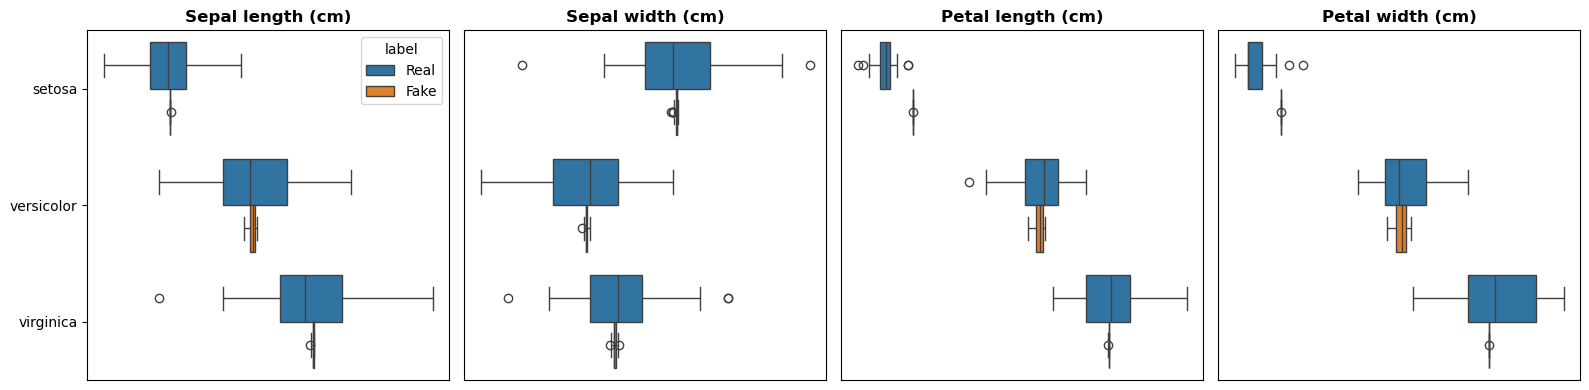

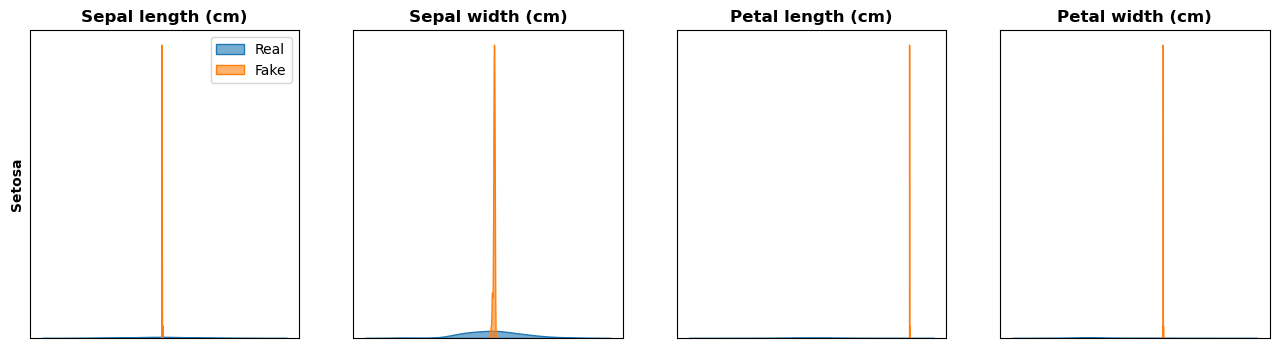

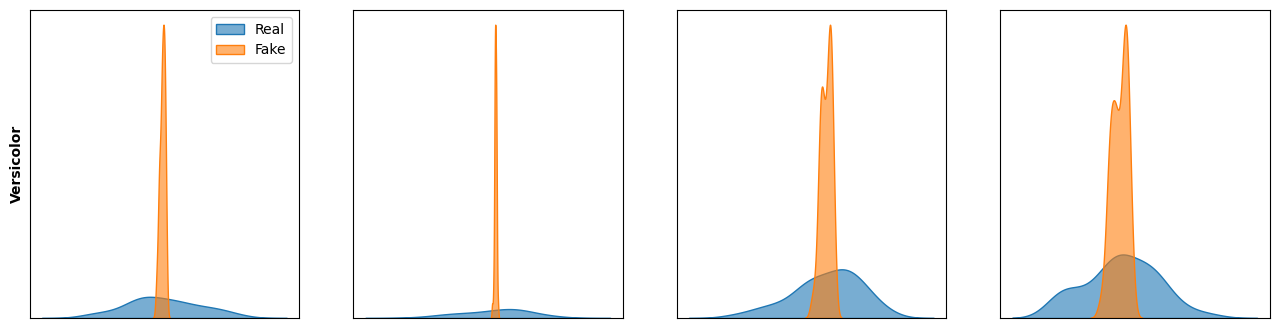

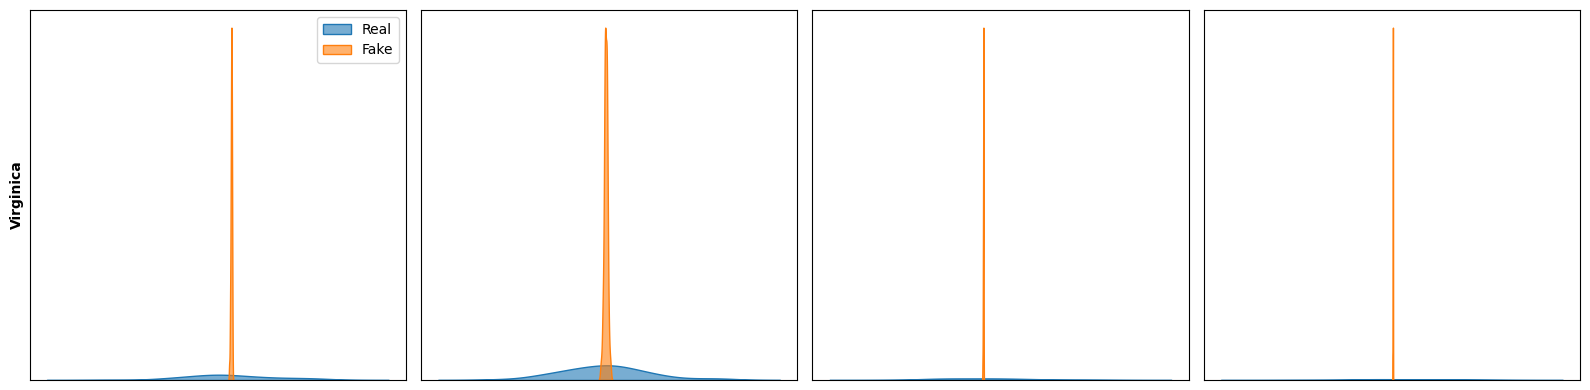

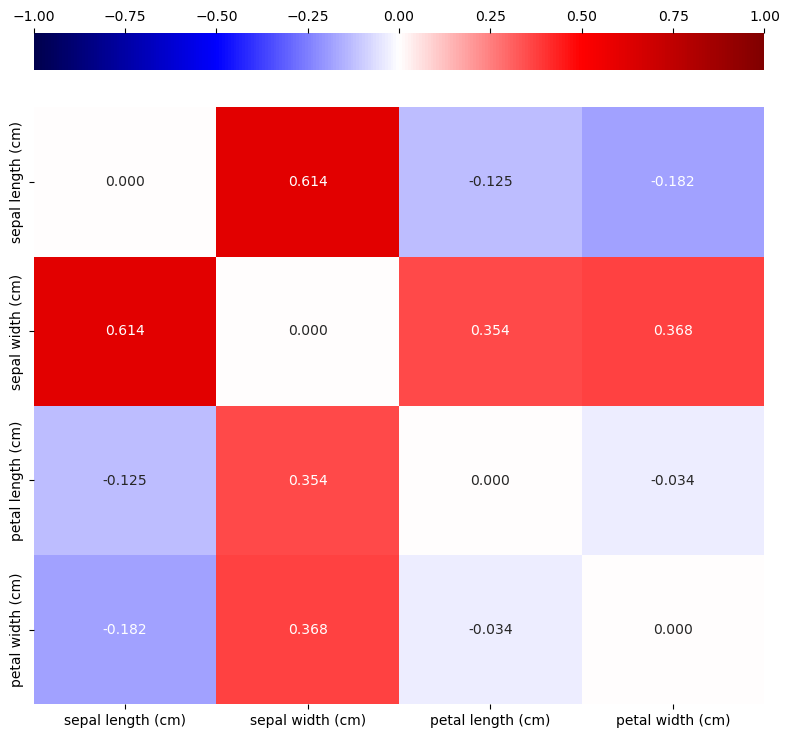

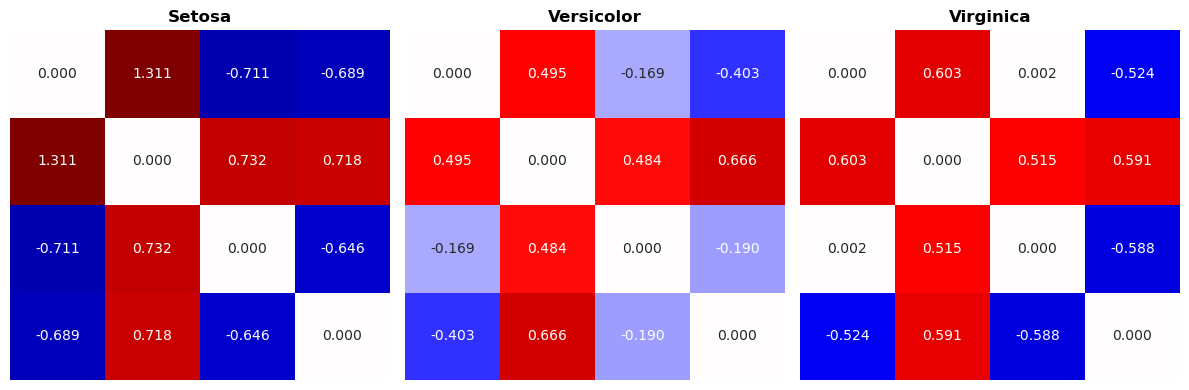

In [19]:
utils.plot_data(real_iris, 'target', vae_df)

Let's train the Conditional GAN.

In [21]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [22]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 10 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/50 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/50 | DLoss: 0.7028 | GLoss 0.6955
MEAN: [ 0.33  -0.002 -0.104 -0.092]
STD:  [0.937 0.945 0.912 0.918]
MIN:  [-1.332 -2.277 -1.355 -1.224]
MAX:  [2.729 2.955 1.45  1.422]
SKEW: [1.168 0.728 0.019 0.604]
KURT: [-0.59   0.44  -2.299 -2.276]

Epoch 10/50 | DLoss: 0.6552 | GLoss 0.7091
MEAN: [ 0.137  0.254  0.131 -0.34 ]
STD:  [0.942 0.883 0.871 0.855]
MIN:  [-1.526 -1.832 -1.009 -1.444]
MAX:  [2.495 3.146 1.707 0.997]
SKEW: [ 0.715  0.875  0.655 -0.495]
KURT: [-0.918  0.736 -1.46  -0.714]

Epoch 20/50 | DLoss: 0.6154 | GLoss 0.8730
MEAN: [-0.778  0.123 -0.508 -0.839]
STD:  [0.775 0.72  0.881 0.709]
MIN:  [-2.219 -1.668 -1.811 -1.832]
MAX:  [1.064 2.666 0.986 0.054]
SKEW: [-0.279  0.45  -0.282 -0.699]
KURT: [-0.521  1.263 -1.137 -1.009]

Epoch 30/50 | DLoss: 0.5266 | GLoss 1.2018
MEAN: [-1.021  1.853 -1.577  1.22 ]
STD:  [0.678 0.388 0.69  0.783]
MIN:  [-2.351  0.853 -2.617  0.712]
MAX:  [ 0.418  3.979 -0.78   2.524]
SKEW: [-0.671  0.659 -1.263  1.172]
KURT: [-1.347  0.911 -2.183 -


Epoch 350/50 | DLoss: 0.6630 | GLoss 0.7221
MEAN: [-0.123  0.148  0.318 -0.069]
STD:  [0.006 0.251 0.111 0.169]
MIN:  [-0.585 -1.197  0.682 -0.036]
MAX:  [-0.203  1.942  1.002  0.222]
SKEW: [-0.154 -0.132  0.215 -0.053]
KURT: [ 0.105  1.59  -0.148 -0.174]

Epoch 360/50 | DLoss: 0.6444 | GLoss 0.7878
MEAN: [-0.035  0.216 -0.033 -0.063]
STD:  [0.085 0.163 0.077 0.359]
MIN:  [-0.448 -0.908  0.251 -0.229]
MAX:  [0.435 1.757 0.557 0.609]
SKEW: [ 0.164 -0.229  0.254  0.127]
KURT: [ 0.452  1.541 -0.077 -0.187]

Epoch 370/50 | DLoss: 0.7076 | GLoss 0.7755
MEAN: [-0.143  0.022 -0.448 -0.074]
STD:  [-0.008  0.048 -0.139  0.275]
MIN:  [-0.461 -0.99  -0.121 -0.25 ]
MAX:  [-0.098  1.208 -0.198  0.32 ]
SKEW: [ 0.066 -0.184  0.272 -0.012]
KURT: [ 0.356  1.56   0.028 -0.126]

Epoch 380/50 | DLoss: 0.6624 | GLoss 0.7521
MEAN: [-0.11  -0.364 -0.322 -0.036]
STD:  [ 0.031 -0.014 -0.101  0.141]
MIN:  [-0.513 -1.043 -0.037 -0.074]
MAX:  [-0.289  0.378  0.036 -0.114]
SKEW: [-0.121  0.312  0.383 -0.069]
KURT

In [23]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

In [24]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.595      5.877   
     sepal width (cm)   3.428      2.770     2.974     3.318      2.645   
     petal length (cm)  1.462      4.260     5.552    -0.010      5.199   
     petal width (cm)   0.246      1.326     2.026    -0.097      1.161   
STD  sepal length (cm)  0.352      0.516     0.636     0.430      0.251   
     sepal width (cm)   0.379      0.314     0.322     0.194      0.146   
     petal length (cm)  0.174      0.470     0.552     0.940      0.266   
     petal width (cm)   0.105      0.198     0.275     0.296      0.071   
MIN  sepal length (cm)  4.300      4.900     4.900     5.308      5.676   
     sepal width (cm)   2.300      2.000     2.200     3.118      2.362   
     petal length (cm)  1.000      3.000     4.500    -2.729      4.470   
     petal width (cm)   0.100      1.000     1.400    -0.865      1.052   
MAX  sepal length (cm)  5.800      7.000     7.900     7.351      6.678   
     sepal width (cm)   4.400      3.400     3.800     3.989      3.072   
     petal length (cm)  1.900      5.100     6.900     1.446      6.079   
     petal width (cm)   0.600      1.800     2.500     0.399      1.530   
SKEW sepal length (cm)  0.116      0.102     0.114     2.598      2.255   
     sepal width (cm)   0.040     -0.352     0.355     1.730      0.894   
     petal length (cm)  0.103     -0.588     0.533    -0.886      0.649   
     petal width (cm)   1.216     -0.030    -0.126    -0.516      2.789   
KURT sepal length (cm) -0.346     -0.599    -0.088     6.588      3.899   
     sepal width (cm)   0.744     -0.448     0.520     3.063      1.024   
     petal length (cm)  0.805     -0.074    -0.256     0.560      2.686   
     petal width (cm)   1.434     -0.488    -0.661    -0.281     12.626   
IQR  sepal length (cm)  0.400      0.700     0.675     0.294      0.102   
     sepal width (cm)   0.475      0.475     0.375     0.230      0.120   
     petal length (cm)  0.175      0.600     0.775     1.353      0.239   
     petal width (cm)   0.100      0.300     0.500     0.444      0.069   

                                  
                       virginica  
MEAN sepal length (cm)     6.716  
     sepal width (cm)      3.049  
     petal length (cm)     4.835  
     petal width (cm)      1.432  
STD  sepal length (cm)     0.565  
     sepal width (cm)      0.276  
     petal length (cm)     0.897  
     petal width (cm)      0.199  
MIN  sepal length (cm)     6.032  
     sepal width (cm)      2.600  
     petal length (cm)     2.217  
     petal width (cm)      0.799  
MAX  sepal length (cm)     8.441  
     sepal width (cm)      3.764  
     petal length (cm)     6.066  
     petal width (cm)      1.664  
SKEW sepal length (cm)     1.070  
     sepal width (cm)      0.517  
     petal length (cm)    -1.095  
     petal width (cm)     -1.407  
KURT sepal length (cm)     0.719  
     sepal width (cm)     -0.285  
     petal length (cm)     0.634  
     petal width (cm)      1.543  
IQR  sepal length (cm)     0.836  
     sepal width (cm)      0.440  
     petal length (cm)     1.286  
     petal width (cm)      0.246

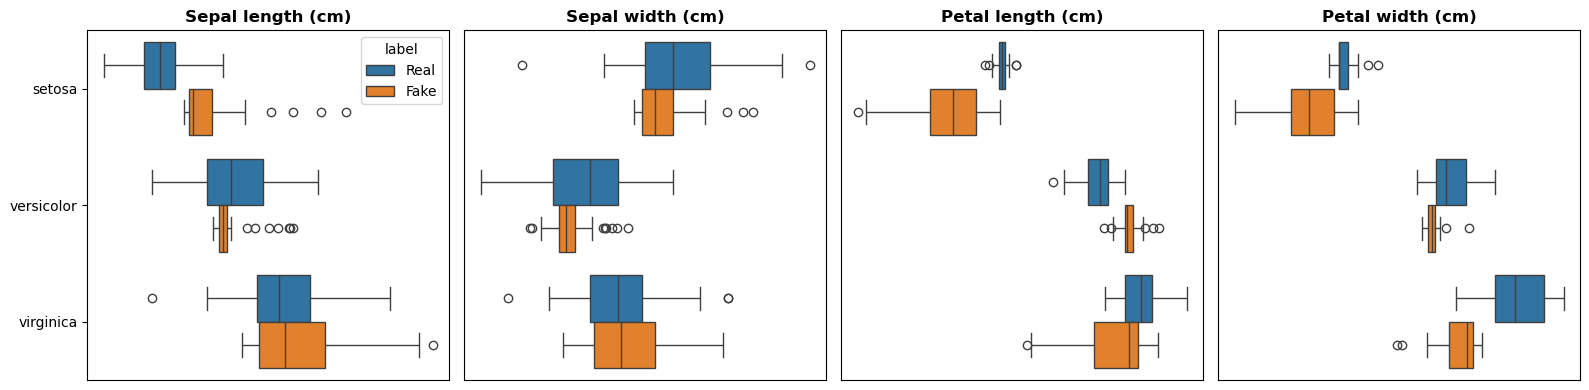

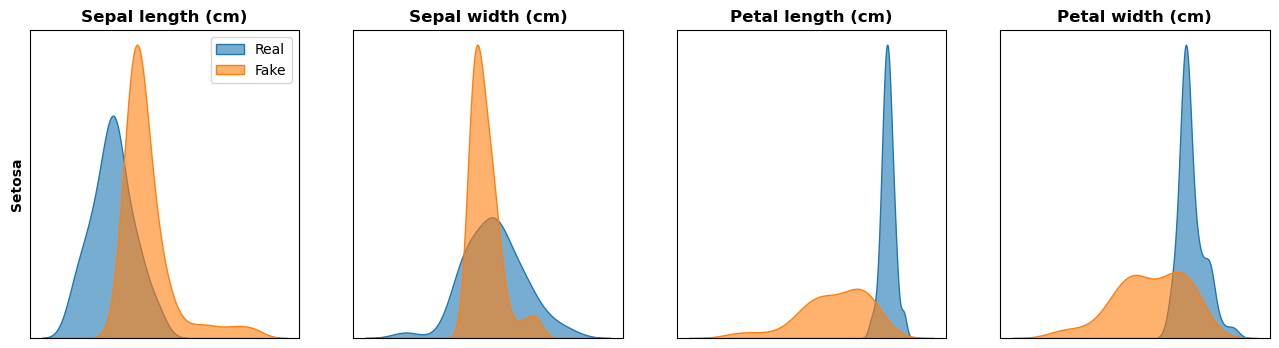

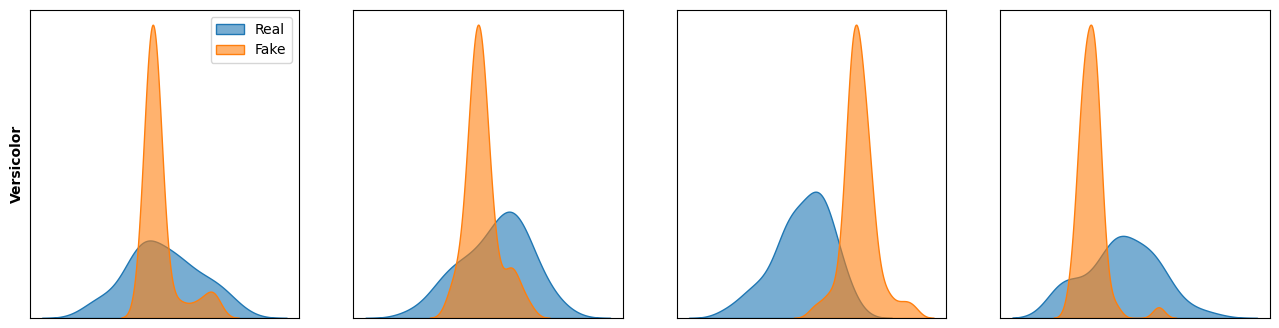

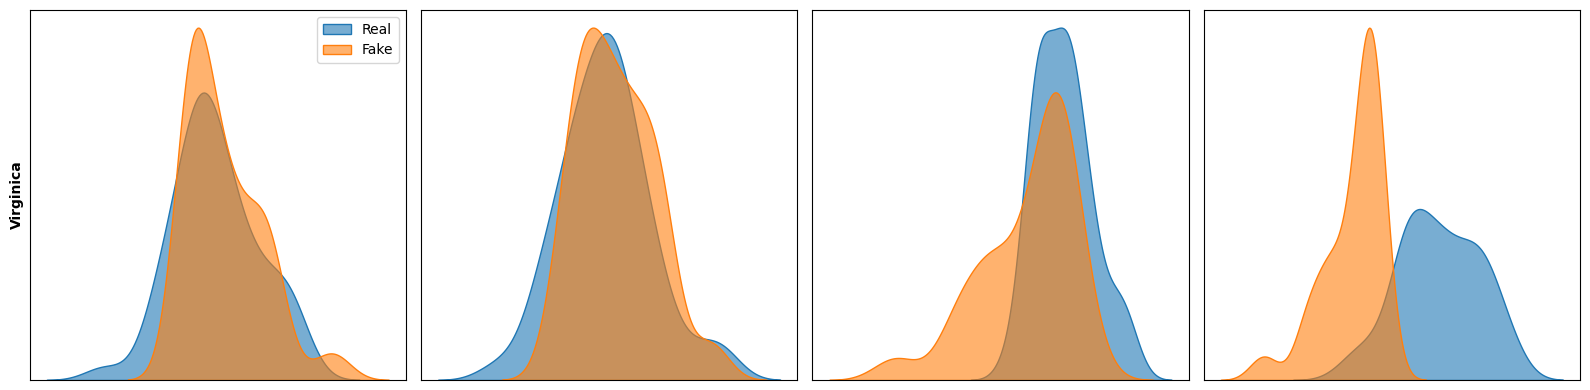

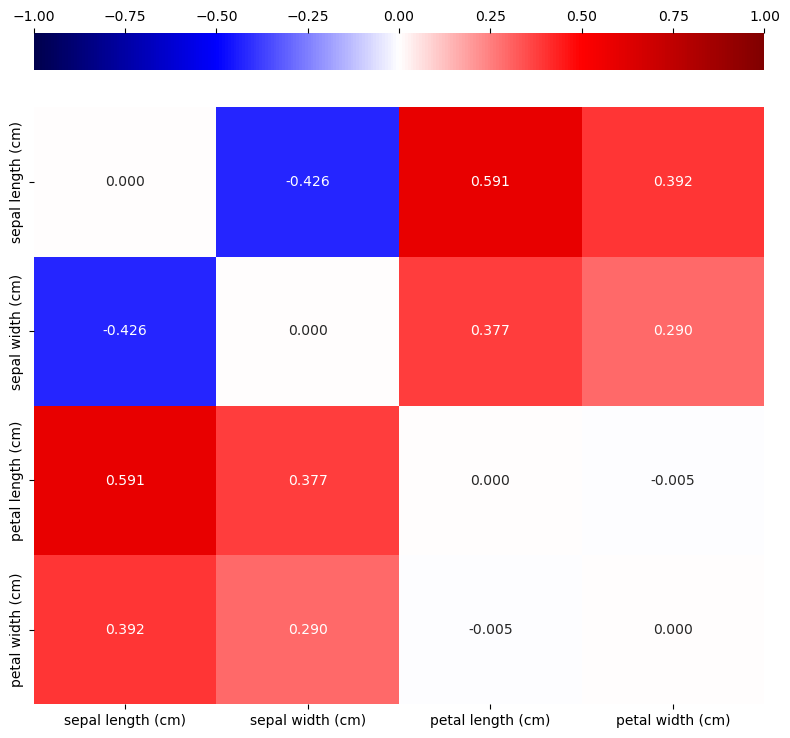

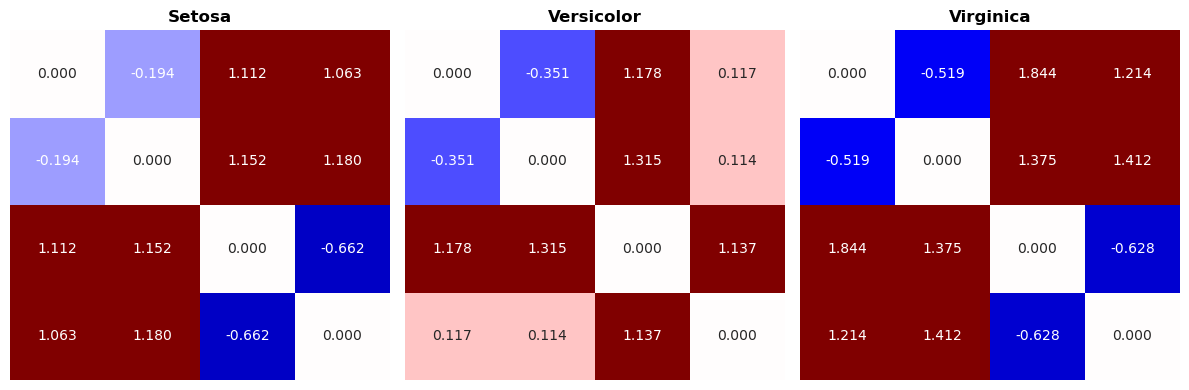

In [25]:
utils.plot_data(real_iris, 'target', gan_df)

In [28]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

array([4.3, 4.4, 4.4, 4.4, 4.5, 4.6, 4.6, 4.6, 4.6, 4.7, 4.7, 4.8, 4.8,
       4.8, 4.8, 4.8, 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 5. , 5. , 5. , 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1,
       5.1, 5.1, 5.2, 5.2, 5.2, 5.2, 5.3, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4,
       5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.6, 5.6, 5.6, 5.6, 5.6, 5.6,
       5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.8, 5.8, 5.8, 5.8, 5.8,
       5.8, 5.8, 5.9, 5.9, 5.9, 6. , 6. , 6. , 6. , 6. , 6. , 6.1, 6.1,
       6.1, 6.1, 6.1, 6.1, 6.2, 6.2, 6.2, 6.2, 6.3, 6.3, 6.3, 6.3, 6.3,
       6.3, 6.3, 6.3, 6.3, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.5, 6.5,
       6.5, 6.5, 6.5, 6.6, 6.6, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7,
       6.8, 6.8, 6.8, 6.9, 6.9, 6.9, 6.9, 7. , 7.1, 7.2, 7.2, 7.2, 7.3,
       7.4, 7.6, 7.7, 7.7, 7.7, 7.7, 7.9])